Copyright (c) 2020 Juergen Koefinger, Max Planck Institute of Biophysics, Frankfurt am Main, Germany

Released under the MIT Licence, see the file LICENSE.txt.

# Description

**Explore the statistical power of the $h$, $h^\pm$, $(\chi^2, h)$, and $(\chi^2, h^\pm)$ test.**

You can provide a file containting a **model for the residuals**. You can generate a model using generate_models_for_residuals.py. 

In this notebooke, we repeatedly add normally distributed noise to the model and calculate the p-values for all tests. These p-values are then collected in **histograms and cumulative histograms**. The latter are the **statistical power** of the test for the given model. 

If **no model is provided** then we use the true model (without noise, all residuals are all zero). In this case, histograms of the p-values are flat and cumulative histograms are equal to the p-value. Calculating these histograms for the true model serves as a check for consistency.

At the end of the notebook, we plot the cumulative **Shannon information distributions (SIDs)** calculated from the Shannon information of all the generated samples. 

# Initialization 

In [3]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rc('axes', labelsize=16) 
import scipy
import sys
sys.path.append("../")
import hplusminus as hpm

In [4]:
title={}
title['chi2_hpm']="$(\chi^2, h^\pm)$-statistic"
title['hpm']="$h^\pm$-statistic"
title['chi2']="$\chi^2$-statistic"
title['h']="$h$-statistic"
title['chi2_h']="$(\chi^2, h)$-statistic"

In [8]:
# Parameters for gamma distribution used to calcualte p-values
gamma_param=hpm.init(gamma_params_ipath="../gamma_spline_parameters/")

# Input

In [30]:
i_path="../examples/"

In [31]:
# Name of file containing model for normalized residuals. REPLACE WITH YOUR OWN! 
file_name_model_for_residuals=i_path+"alternative_model.txt"

#Set file_name="" and set number of data points to use true model. 
# file_name_model_for_residuals=""
# number_data_points = 5000

In [32]:
if file_name_model_for_residuals == "":
    # Generate true model, i.e., all model residuals equal zero. 
    try:
        print("Generating true model")
        print("number_data_points = %d" % number_data_points)
    except:
        print("Error: Set positive integer value for number_data_points")
    model_for_residuals  = np.zeros(number_data_points)
else:
     # Read in model for normalized residuals (without noise!) from file. 
    print("Loading residuals from \"%s\"" % file_name_model_for_residuals)

    model_for_residuals = np.loadtxt(file_name_model_for_residuals)
    number_data_points = model_for_residuals.shape[0]

Loading residuals from "../examples/alternative_model.txt"


In [33]:
# Number of samples
n_sample=10000

In [34]:
# P-values
p_values={}
# Shannon information
I={}
tests=["chi2", "hpm", "h", "chi2_h", "chi2_hpm"]
for t in tests:
    p_values[t]=np.zeros(n_sample)
    I[t]=np.zeros(n_sample)

# P-value Distribution Function

In [23]:
for i in range(n_sample):
    # Add normal noise to model residuals.
    normalized_residuals = model_for_residuals+np.random.normal(0,1,number_data_points)
    signs=np.sign(normalized_residuals)

    #Calculate histograms
    num, blockLen, histo, edges = hpm.get_run_length_distributions(signs)
    chi_square=(normalized_residuals**2).sum()
    I['chi2'][i] = hpm.SI_chi2(chi_square, number_data_points)
    I['hpm'][i] = hpm.SI_hpm(number_data_points, num[1], histo['plus'], histo['minus'])
    I['h'][i] = hpm.SI_h(number_data_points, histo['all'])
I['chi2_h'] = I['h'] + I['chi2']
I['chi2_hpm'] = I['hpm'] + I['chi2']

In [24]:
for test in I:
    p_values[test]=hpm.get_p_value(I[test], number_data_points, test, gamma_param)

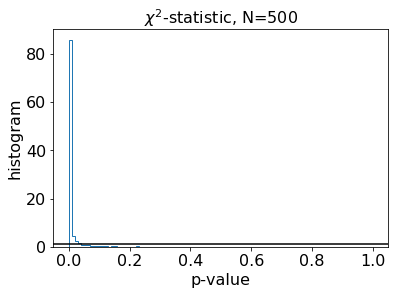

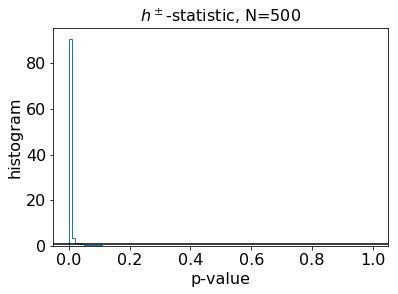

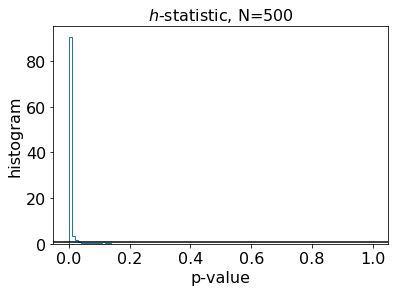

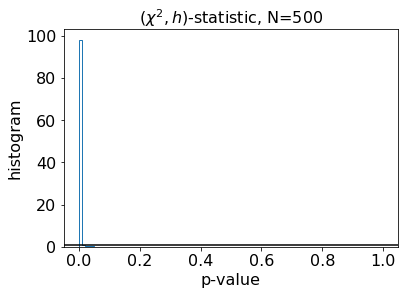

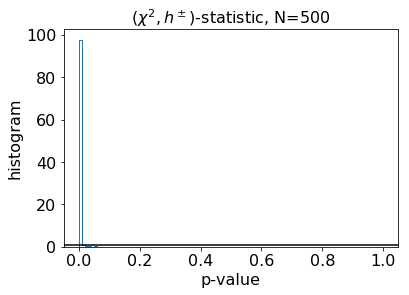

In [26]:
for t in tests:
    plt.title("%s, N=%d" % (title[t], number_data_points), size=16)
    h, e, dummy = plt.hist(p_values[t], bins=100, range=(0,1), density=True, histtype="step")
    plt.axhline(1, c='k')
    plt.ylim(bottom=0)
    plt.xlabel("p-value")
    plt.ylabel("histogram")
    plt.show()

# Statistical Power

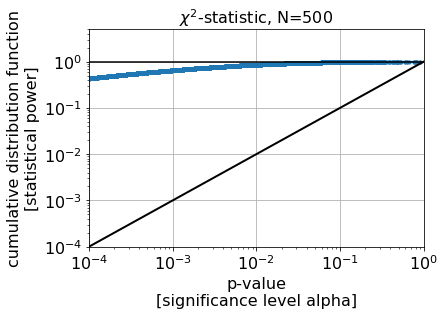

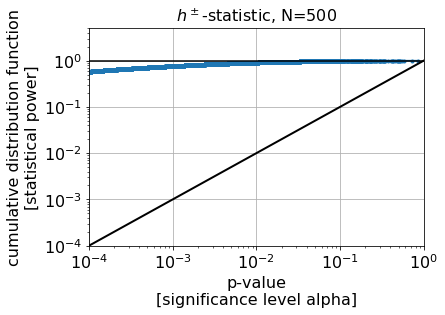

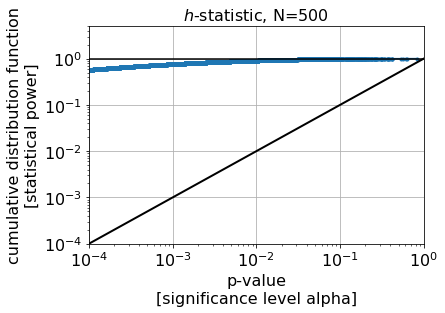

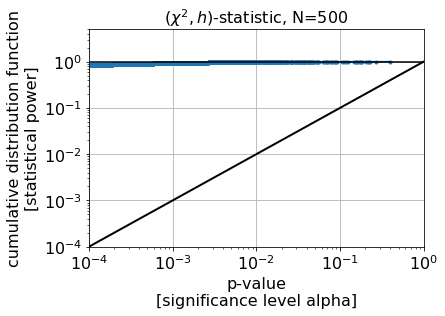

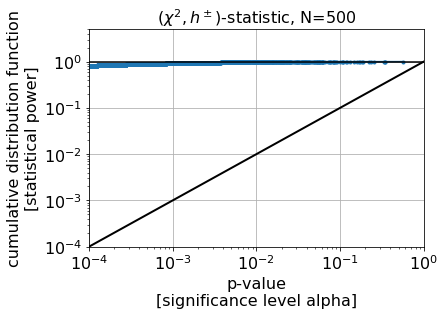

In [28]:
for t in tests:
    plt.title("%s, N=%d" % (title[t], number_data_points), size=16)
    p_values_tmp=np.sort(p_values[t])
    cdf=np.arange(p_values_tmp.shape[0])/float(p_values_tmp.shape[0])
    plt.plot(p_values_tmp, cdf, '.-')
    plt.xscale('log')
    plt.yscale('log')
    (xmin, xmax)=plt.gca().get_xlim()
    (ymin, ymax)=plt.gca().get_xlim()
    dummy=np.linspace(min(xmin, ymin),1,100)
    plt.plot(dummy, dummy, lw=2, c='k')
    plt.xlabel("p-value\n[significance level alpha]")
    plt.ylabel("cumulative distribution function\n[statistical power]")
    plt.axhline(1, c='k')
    plt.grid()
    plt.ylim(1e-4, 5)
    plt.xlim(1e-4,1)
    q_save_fig=False
    if q_save_fig:
        oname="p-value_cumu_gamma_%s_Ns%d_nsample%d" % (t, number_data_points, n_sample)
        print(oname)
        for fmt in ['.jpg','.png']:
            plt.savefig(oimg+oname+fmt, dpi=600,  bbox_inches='tight')
    q_save_fig=False
    plt.show()

# Plotting the Cumulative Shannon Information Distributions (SIDs)

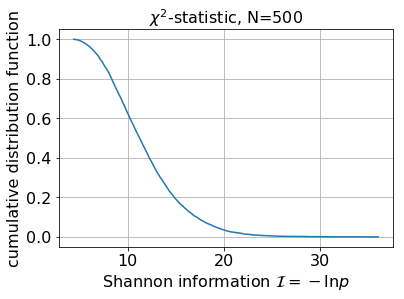

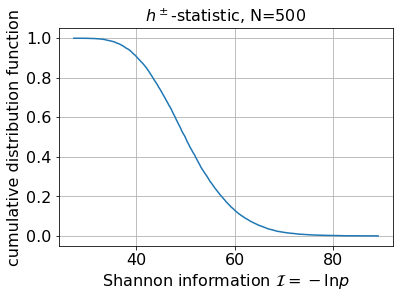

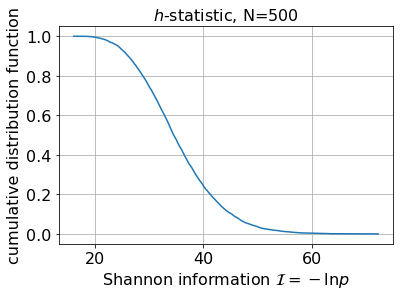

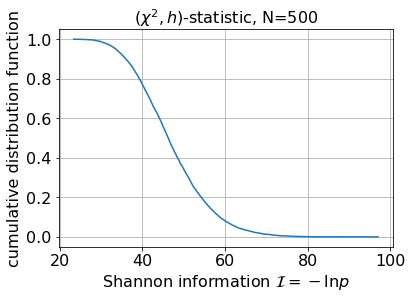

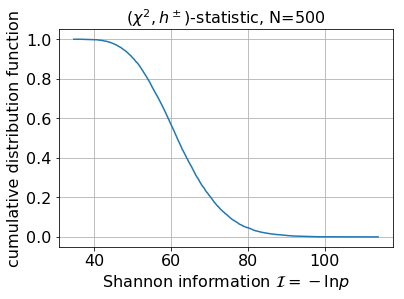

In [29]:
for t in tests:
    I_tmp=np.sort(I[t])[::-1]
    cdf=np.arange(1,I_tmp.shape[0]+1)/float(I_tmp.shape[0])
    plt.title("%s, N=%d" % (title[t], number_data_points), size=16)
    plt.xlabel(r"Shannon information $\mathcal{I}=-\ln p$")
    plt.ylabel("cumulative distribution function")
    plt.plot(I_tmp, cdf)
    plt.grid()
    plt.show()